<a href="https://www.kaggle.com/code/gamzebayir/customer-segmentation-with-k-means-and-rfm-score?scriptVersionId=94144214" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii/online_retail_10_11.csv
/kaggle/input/online-retail-ii/online_retail_09_10.csv


In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

In [3]:
def data_preparing(df):
    pd.set_option('display.max_columns', None)
    print(df.head())
    print(df.info())
    print(df.shape)
        # 3. are there any null values?
    print(f"Count of null values: {df.isnull().sum()}")
        # 4. drop null values
    df.dropna(inplace=True)
        # 5. How many unique items are there ?
    print(f"Unique items: {df.nunique()}")
        # 6. How many of each product are there?
    df["Description"].value_counts().head()
        # 7. Sort 5 most ordered products from most to least.
    df["Description"].value_counts().sort_values(ascending=False).head(5)
        # 8. The 'C' in the invoices shows the canceled transactions. Remove the canceled transactions from the dataset.
    df[~df["InvoiceNo"].str.contains("C", na=False)].head()
        #select values greater than 0(zero)
    df=df[(df["Quantity"]>0)]
    df=df[(df["UnitPrice"]>0)]

In [4]:
def RFM_Metrics_Calculation(df):
    df['InvoiceDate'] = df['InvoiceDate'].astype('datetime64[ns]')
        # 9. Create a variable named 'TotalPrice' that represents the total earnings per invoice
    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
        #get today date
    today_date = dt.datetime(2011, 12, 11)
        #calculate RFM metrics
    rfm = df.groupby('CustomerID').agg(
          {
             'InvoiceDate': lambda date_: (today_date - date_.max()).days,
             'InvoiceNo': lambda x: x.nunique(),
             'TotalPrice': lambda x: x.sum()})

    rfm.reset_index(drop=False, inplace=True)

    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    rfm.head()
    rfm = rfm[(rfm["Monetary"] > 0)]
    return rfm


In [5]:
def Calculating_rfm_score(rfm):

    rfm["Recency_score"] = pd.qcut(rfm["Recency"].rank(method="first"), 5, labels=[5, 4, 3, 2, 1])
    rfm["Frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["Monetary_score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["RFM_SCORE"] = rfm["Recency_score"].astype(str) + rfm["Frequency_score"].astype(str)

    # create segments
    seg_map = {
            r'[1-2][1-2]': 'hibernating',
            r'[1-2][3-4]': 'at_risk',
            r'[1-2]5': 'cant_loose',
            r'3[1-2]': 'about_to_sleep',
            r'33': 'need_attention',
            r'[3-4][4-5]': 'loyal_customers',
            r'41': 'promising',
            r'51': 'new_customers',
            r'[4-5][2-3]': 'potential_loyalists',
            r'5[4-5]': 'champions'
             }
        # apply segments
    rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)
    return (rfm)



In [6]:
def K_means_Cluster(rfm):
    rfm_ci = rfm[['CustomerID', 'segment']]
    rfm = rfm[['Recency', 'Frequency', 'Monetary']]
    sc = MinMaxScaler((0, 1))
    rfm_ci = pd.DataFrame(rfm_ci)
    rfm = sc.fit_transform(rfm)


    kmeans = KMeans()
    ssd = []
    K = range(1, 30)

    for k in K:
        kmeans = KMeans(n_clusters=k).fit(rfm)
        ssd.append(kmeans.inertia_)

    elbow=KElbowVisualizer(kmeans,k=(2,20))
    elbow.fit(rfm)
    #elbow.show()

    kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(rfm)
    kumeler = kmeans.labels_
    len(kumeler)
    rfm.shape

    final_df = pd.DataFrame({"CustomerID": rfm_ci.CustomerID, "Cluster(K_Means)": kumeler, "Segment": rfm_ci.segment})
    final_df["Cluster(K_Means)"] = final_df["Cluster(K_Means)"] + 1
    return final_df

In [7]:
df_=pd.read_csv("../input/online-retail-ii/online_retail_10_11.csv")

In [8]:
df=df_.copy()

In [9]:
data_preparing(df)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [10]:
rfm=RFM_Metrics_Calculation(df)

In [11]:
rfm=Calculating_rfm_score(rfm)

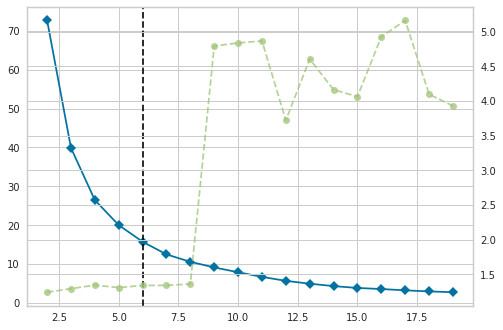

In [12]:
final_df=K_means_Cluster(rfm)

In [13]:
final_df.groupby(["Cluster(K_Means)","Segment"]).count()

CustomerID
Cluster(K_Means) Segment                        
1                at_risk                     234
                 cant_loose                   20
                 hibernating                 257
2                about_to_sleep              269
                 at_risk                     223
                 cant_loose                   41
                 hibernating                 204
                 loyal_customers             187
                 need_attention              115
3                at_risk                     112
                 cant_loose                    6
                 hibernating                 333
4                about_to_sleep               95
                 champions                   614
                 loyal_customers             605
                 need_attention               68
                 new_customers                40
                 potential_loyalists         480
                 promising                    95
5                at_risk                      43
                 cant_loose                    4
                 hibernating                 251
6                champions                    21
                 loyal_customers               3